# Notebook on the (non) stability of some problem with matrices

First, Python's boilerplate

In [1]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import linalg
from IPython.display import display

sns.set(rc={"figure.figsize": (12, 12), "figure.dpi": 80}, style="whitegrid")
np.set_printoptions(precision=3)

We consider complex $3 \times 3$ matrices $M(t) \in \Complex^{3 \times 3 }$ with a real parameter $t \in \Reals$ of the following form, with general term $M(t)_{x,y} = e^{k_{x,y}ti}$

$$
\begin{bmatrix}
    e^{k_{1,1}ti}&e^{k_{1,2}ti}&e^{k_{1,3}ti}\\
    e^{k_{2,1}ti}&e^{k_{2,2}ti}&e^{k_{2,3}ti}\\
    e^{k_{3,1}ti}&e^{k_{3,2}ti}&e^{k_{3,3}ti}\\
\end{bmatrix}
$$

Coefficients $k_{x,y}$ constitue a $3 \times 3$ indexed sequence of real numbers, for instance $(1,2, \dots, 9)$ or $(\sqrt{1}, \sqrt{2}, \dots, \sqrt{19})$  the square roots of the first prime numbers.


In [2]:
# primes nombers
primes = [1, 2, 3, 5, 7, 11, 13, 17, 19, 23, 29, 31, 37, 41, 43, 47, 53, 59, 61, 67, 71, 73, 79, 83, 89, 97]
NDIM = 3


def gen_matrix(t=1, factors=None):
    """For factors [k1, ...k9], computes a matrix M with general term e^(ki * t * j) where 'j' is the imaginary number"""
    # default value
    if factors is None:
        factors = np.sqrt(primes[: NDIM**2])
    return np.exp(np.array(factors, dtype=np.cdouble) * t * 1j).reshape(NDIM, NDIM)



We display for instance the matrix $M(1)$ below.

M as shape (3, 3) with values of type complex128. Content is as follows:


array([[ 0.54 +0.841j,  0.156+0.988j, -0.161+0.987j],
       [-0.617+0.787j, -0.88 +0.476j, -0.985-0.174j],
       [-0.894-0.447j, -0.556-0.831j, -0.346-0.938j]])

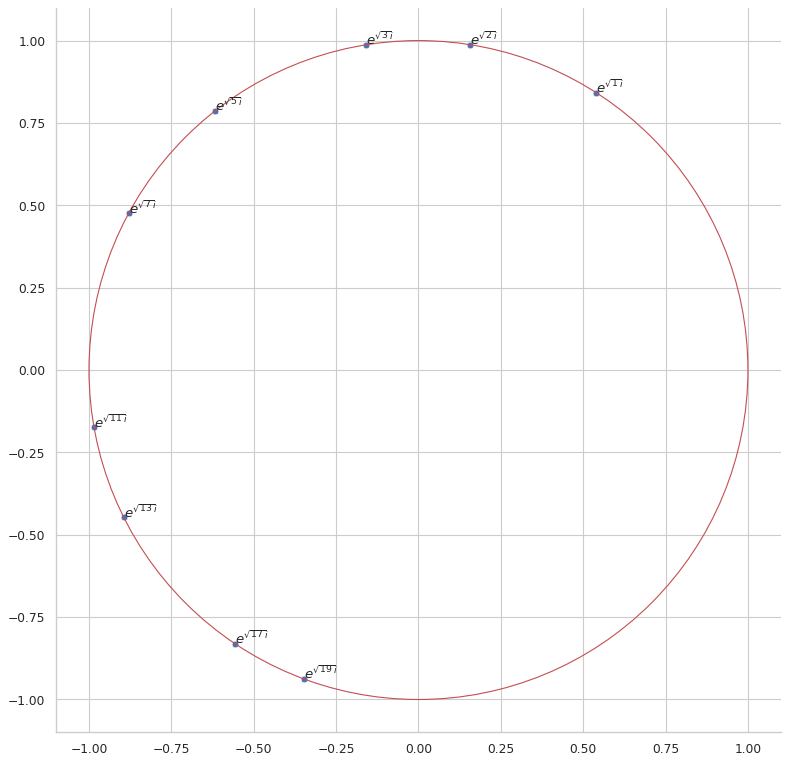

In [3]:
M = gen_matrix(1)
print(f"M as shape {M.shape} with values of type {M.dtype}. Content is as follows:")
display(M)

x_coords, y_coords = np.real(M.flatten()), np.imag(M.flatten())
ax = sns.scatterplot(x=x_coords, y=y_coords)
# ax.figure.set_size_inches(4, 4)
ax.set_aspect("equal", "box")
unit_circle = plt.Circle((0, 0), 1, edgecolor="r", fill=False)
ax.set(xlim=(-1.1, 1.1), ylim=(-1.1, 1.1))
ax.add_patch(unit_circle)
for i in range(M.size):
    ax.annotate(f"$e^{{\sqrt{{{primes[i]}}}i}}$", (x_coords[i], y_coords[i]), rotation=0)
sns.despine()


Now, we extract the 3 eigenvalues and associated eigenvectors from a matrix.
Eigenvalues are sorted in decreasing order of their absolute values (a.k.a. modulus).
Eigenvectors are sorted accordingly.

In [4]:
def extract_eivs(m):
    """Returns complex eigenvalues in decreasing order of module and their eigenvectors"""
    vals, vecs = linalg.eig(m)
    order = np.argsort(-np.absolute(vals))
    
    # NOTE : mind the direction of vectors written as **columns** in vecs
    return np.take_along_axis(vals, order, axis=None), np.take_along_axis(vecs, order.reshape(1,-1), axis=1)


As an example, let's extract eigenvalues $v_i$ and vectors $\lambda_i$ from $M(1)$ and do some sanity checks :
- the eigenvectors are normalized
- eigenvectors $v_i$ are such that $\lambda_i v_i =  M v_i$

In [5]:
vals, vecs = extract_eivs(M)
print(f"Eigenvalues: {vals}")
print(f"Absolute values (sorted): {np.absolute(vals)}")
print(f"Eigenvectors:\n{vecs}")

# sanity check on each dimension
for n in range(NDIM):
    # chek that the n-th eigenvectors is related to the n-th eigenvalue
    redo = M @ vecs[:, n]
    norm = np.sum(np.absolute(vecs[:, n] * vecs[:, n]))
    assert np.allclose(redo, vals[n]*vecs[:, n])
    assert np.isclose(norm, 1.0)


Eigenvalues: [-0.231+0.684j -0.384-0.367j -0.07 +0.062j]
Absolute values (sorted): [0.722 0.532 0.094]
Eigenvectors:
[[ 0.604+0.j    -0.573-0.231j  0.757+0.j   ]
 [ 0.402+0.382j  0.318-0.31j  -0.582+0.088j]
 [-0.52 +0.238j  0.649+0.j     0.018+0.284j]]


Now, with given a minimum time $t_1$, a maximum time $t_n$ and a number of points $n$, we generate a sequence of equally spaced points in time $T = (t_1, \dots, t_n)$, then we compute all $M(t_i)$ and their associated eigenvalues and vectors.

In [6]:
def get_all_eivs(mini, maxi, nb):
    """Returns a 3*nb array of eigenvalues : 1st row the largest modulus of each matrix, 2nd and 3rd, for nb parameters betwen mini an dmaxi

    ts: the points in time
    vals: the eigenvalues
    vecs: the eigenvectors
    """
    ts = np.linspace(mini, maxi, nb)
    res = [extract_eivs(gen_matrix(t)) for t in ts]
    # unzip
    vals, vecs = zip(*res)
    # vals = np.apply_along_axis(lambda t: extract_eivs(gen_matrix(t))[1], 0, ts.reshape(1, -1))
    # vecs = np.apply_along_axis(lambda t: extract_eivs(gen_matrix(t))[1], 0, ts.reshape(1, -1))

    return ts, np.array(vals), np.array(vecs)


For instance, for points in time $t \in (0, 2)$ we got the following datasets :

In [7]:
ts, vs, es = get_all_eivs(0, 2, 2)
print(f"A sequence of length 2 of points in time\n{ts}")
print(f"A sequence of length 2 of {NDIM} eigenvalues\n{vs}")
print(f"A sequence of length 2 of {NDIM} eigenvectors, each one of dimension {NDIM}\n{es}")


A sequence of length 2 of points in time
[0. 2.]
A sequence of length 2 of 3 eigenvalues
[[ 3.000e+00+0.j    -9.065e-17+0.j     0.000e+00+0.j   ]
 [-5.051e-01+1.338j  4.263e-02-0.567j -1.667e-01-0.048j]]
A sequence of length 2 of 3 eigenvectors, each one of dimension 3
[[[ 0.577+0.j     0.816+0.j    -0.   -0.j   ]
  [ 0.577-0.j    -0.408-0.j     0.707+0.j   ]
  [ 0.577-0.j    -0.408-0.j    -0.707-0.j   ]]

 [[ 0.271+0.547j -0.363-0.229j  0.736+0.j   ]
  [-0.258-0.371j  0.837+0.j    -0.317+0.593j]
  [ 0.651+0.j    -0.332-0.073j -0.047+0.062j]]]


For instance, we draw the absolute values on the interval $[0, 10]$ with precision $1/100$.

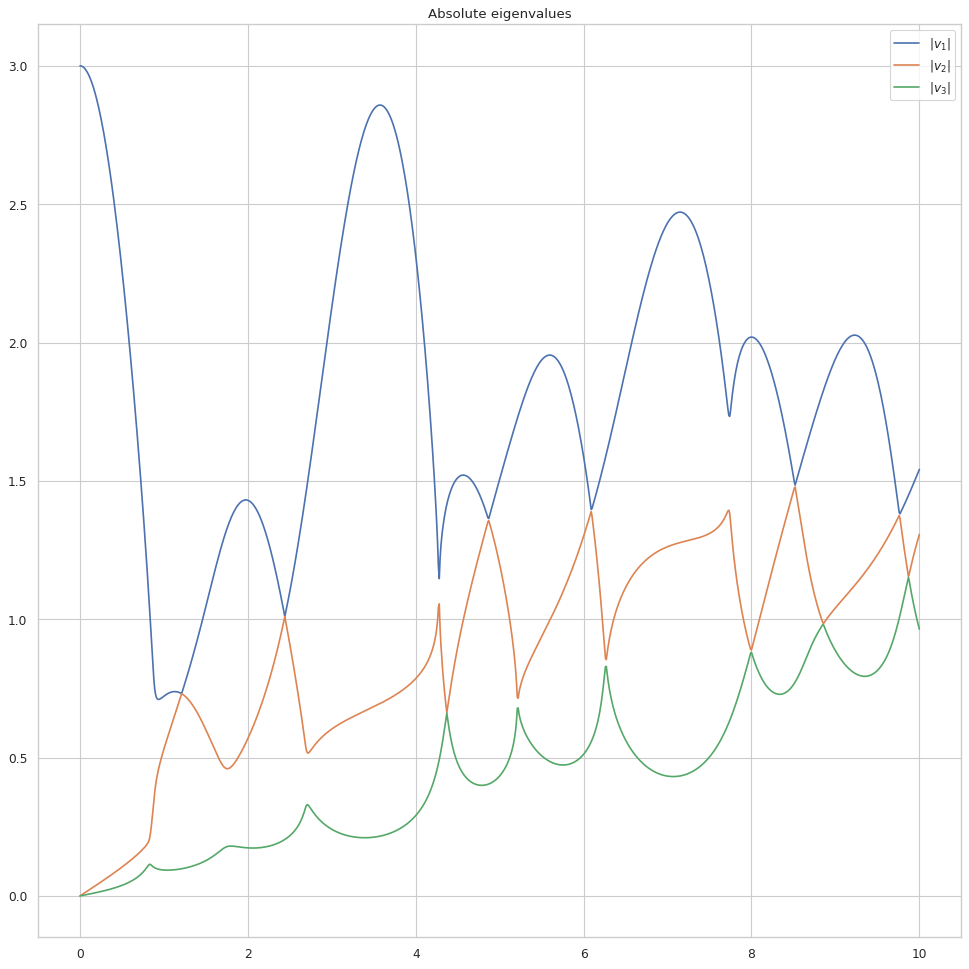

In [8]:
ts, vals, vecs = get_all_eivs(0, 10, 1_001)
fig, ax = plt.subplots(constrained_layout=True)
for k in range(NDIM):
    # print(k, vals[:,k])
    
    # plt.xticks(ticks = np.linspace(MIN, MAX*np.pi/2, X_STEPS), labels = [f"${x}\\times \\frac{{\\pi}}{{2}}$" for x in range(X_STEPS)])
    k_th_vals = vals[:, k]
    sns.lineplot(x=ts, y=np.absolute(k_th_vals), label=f"$|v_{k+1}|$", ax=ax)
    # sns.lineplot(x=ts, y=np.angle(k_th_vals), label="angle", ax=ax)
    # sns.lineplot(x=ts, y=np.real(k_th_vals), label="real", ax=ax)
ax.set_title(f"Absolute eigenvalues")
plt.show()


From now on, we generate a larger dataset on the interval $[0, 10.000]$ with precision $1/100$, with 1 million matrixes and eigs.

In [9]:
ts, vals, vecs = get_all_eivs(0, 10_000, 1_000_001)

Let $\lambda_1(t)$, $\lambda_2(t)$ and $\lambda_3(t)$ the eigenvalues at point $t$ ordered decreasingly.
Let $v_1(t)$, $v_2(t)$ and $v_3(t)$ their respective eigenvectors.
We are interested into the subset of $I$ of  _interesting points_ such that $\lambda_1(t)$ and $\lambda_2(t)$ are close enough  for some fixed threshold value $k$, i.e., $I = \{t \mid ||\lambda_1(t)| - |\lambda_2(t)|| < k^{-1}\}$.


In [10]:
THRESHOLD = 10000
# I_filter = np.abs(np.absolute(vals[:, 0]) - np.absolute(vals[:, 1])) < 1 / THRESHOLD
I_filter = np.isclose(np.absolute(vals[:, 0]), np.absolute(vals[:, 1]), atol=1 / THRESHOLD, rtol=0.0)
I_points = ts[I_filter]
I_idx = np.arange(len(ts))[I_filter]
print(f"{len(I_points)} interesting points are at times {I_points}")
print(f"Differences between top eigs are {np.absolute(vals[I_filter,0]) - np.absolute(vals[I_filter,1])}")


120 interesting points are at times [  79.58   90.72  185.4   278.46  436.24  502.58  507.59  524.8   537.59
  697.86  726.47  727.85  734.21  754.1   771.81  793.55  883.41  964.06
 1083.36 1252.81 1293.55 1334.08 1706.84 1872.46 1882.47 2059.99 2066.34
 2084.5  2084.52 2122.64 2162.17 2195.05 2445.35 2696.37 2715.93 2825.52
 2839.34 3047.87 3075.55 3349.87 3713.36 3866.73 3992.89 4047.51 4078.46
 4293.55 4334.02 4391.52 4481.76 4556.53 4640.37 4642.66 4712.21 4766.59
 4860.71 4940.99 4978.56 4983.63 5018.7  5098.08 5520.79 5621.87 5914.31
 5980.58 6057.4  6061.48 6084.2  6289.3  6347.52 6377.85 6491.74 6529.02
 6595.1  6727.75 6865.04 6911.85 6954.23 7077.82 7254.26 7257.5  7389.22
 7521.38 7536.37 7541.07 7543.53 7554.51 7563.14 7704.37 7754.48 7766.36
 7781.67 7799.33 7965.83 8117.14 8135.41 8306.1  8350.5  8356.94 8375.73
 8595.53 8784.98 8786.05 8959.39 8992.8  9015.17 9063.97 9233.92 9294.25
 9350.41 9450.77 9454.59 9527.14 9617.87 9743.51 9750.12 9941.21 9954.84
 9978.19 9991.9

The inverse of the difference can be drawn, so pikes highlight points $t_x$ where $|\lambda_1(t_x)|$ and $|\lambda_2(t_x)|$ are close.

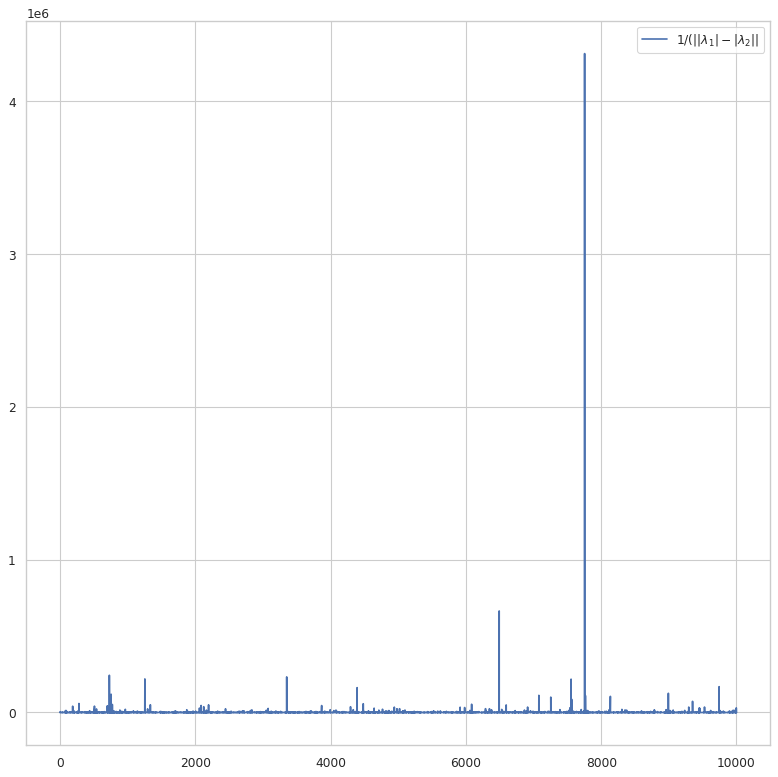

In [11]:
sns.lineplot(
    x=ts,
    y=np.absolute(1 / np.abs(np.absolute(vals[:, 0]) - np.absolute(vals[:, 1]))),
    label=f"$1/(||\lambda_1| - |\lambda_2||$",
)
plt.show()


Now, for matrices $\{ M(t_x) | t_x \in I\}$, we compute the following _ratio_ for all dimension $i \in \{1,2,3\}$ 

$$ \frac{x^i_1}{x^i_2}. \frac{\theta_1}{\theta_2}$$

where $\lambda_1(t_x) = r_1(t_x).e^{\theta_1(t_x) i}$ is the largest eigenvalue, $\lambda_2(t_x) = r_2(t_x).e^{\theta_2(t_x) i}$ is the second one, $v_1(t_x) = (x^1_1(t_x), x^2_1(t_x), x^3_1(t_x))$ is the first eigenvector and $v_2(t_x) = (x^1_2(t_x), x^2_2(t_x), x^3_2(t_x))$ is the second one.

In [12]:
print(f"Eigenvalues at interesting points t_x:\n{vals[I_filter, 0:2]}")
print(f"Differences\n{np.absolute(vals[I_filter, 0]) - np.absolute(vals[I_filter, 1])}")

ratios = (vecs[I_filter, :, 0] * np.angle(vals[I_filter, 0]).reshape(-1,1)) / (vecs[I_filter, :, 1] * np.angle(vals[I_filter, 1]).reshape(-1,1))
print(f"Ratios\n{ratios}")


Eigenvalues at interesting points t_x:
[[ 0.502+1.732j -1.658-0.709j]
 [-0.88 +0.52j   0.405+0.939j]
 [-0.738+1.45j  -0.745-1.447j]
 [-0.954+1.58j  -0.095+1.843j]
 [-0.847+1.628j -0.375-1.796j]
 [ 1.951-0.402j -1.783-0.888j]
 [ 1.003-1.339j -1.519-0.7j  ]
 [-1.45 +0.341j  1.265+0.787j]
 [ 0.402-1.205j -0.217+1.251j]
 [ 1.591+0.164j  0.503+1.518j]
 [ 1.93 +0.309j -1.611-1.106j]
 [-1.62 +0.38j   0.691-1.513j]
 [ 0.483+1.715j  0.793-1.596j]
 [ 1.415-0.364j -1.461-0.028j]
 [ 0.292-1.575j -1.176+1.088j]
 [-0.536+1.414j -1.477-0.324j]
 [ 1.673+0.029j -0.846-1.444j]
 [ 0.709-1.502j -1.65 +0.188j]
 [ 0.225+1.35j  -0.99 -0.945j]
 [ 1.108+1.521j -1.724+0.752j]
 [ 0.222-1.734j -1.308+1.159j]
 [-0.857-0.884j -0.702+1.012j]
 [-0.215-1.409j  1.418+0.142j]
 [-1.558+0.513j  1.369-0.904j]
 [-0.45 -1.463j  1.512-0.234j]
 [ 1.413-0.092j -1.365+0.379j]
 [ 0.255+1.205j  0.211-1.213j]
 [-1.228-0.856j  1.048-1.069j]
 [-1.191-0.909j  1.081-1.038j]
 [-0.982-1.102j -0.488-1.393j]
 [ 1.656-0.227j -1.667-0.116j]


Now, we draw the 1st ratios in the complex plane.

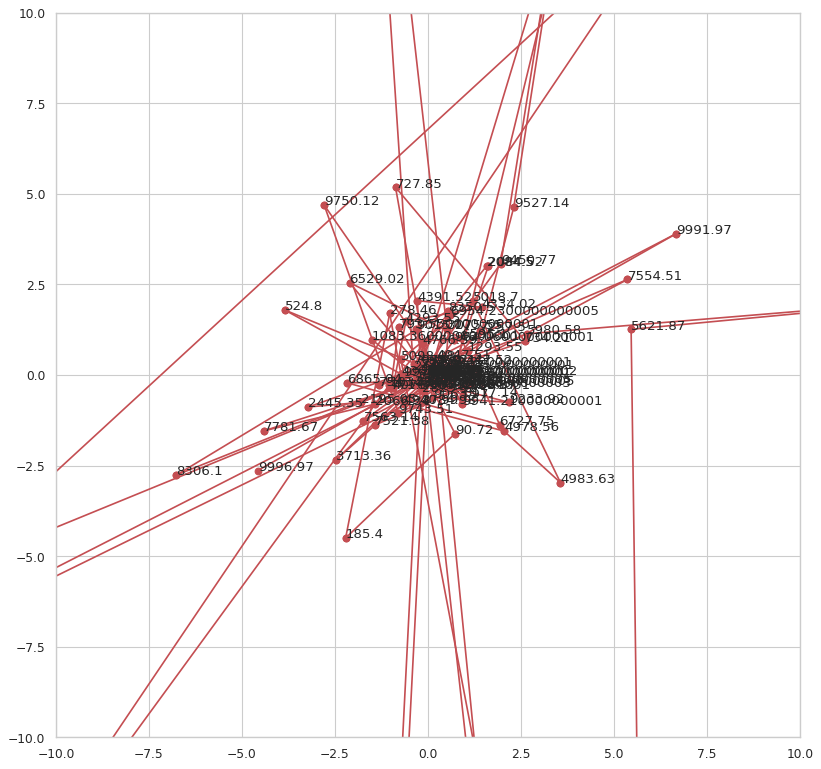

In [13]:
# first component only
# arr = ratios[:,1]

# plot = sns.scatterplot(x = np.real(arr), y=np.imag(arr))
# for i, tx in enumerate(ts[I_filter]):
#     plot.annotate(str(tx), (np.real(arr[i]), np.imag(arr[i])), rotation=0)

XS = (-10, 10)
YS = (-10, 10)
arr = ratios[:,1]
ax = plt.subplot()
for i, tx in enumerate(ts[I_filter][:-1]):
    # p1 = np.real(arr[i]), np.imag(arr[i])
    # p2 = np.real(arr[i+1]), np.imag(arr[i+1])
    xs = np.real(arr[i]), np.real(arr[i+1])
    ys = np.imag(arr[i]), np.imag(arr[i+1])
    ax.plot(xs, ys, 'ro-')
    ax.annotate(f"{tx}", (xs[0], ys[0]))
ax.annotate(f"{ts[I_filter][-1]}", (xs[1], ys[1]))

# ax.margins(x=0, y=-0.25)
ax.set_xlim(-10, 10)
ax.set_ylim(-10, 10)
plt.show()